In [3]:
%matplotlib inline

import matplotlib.pylab as plt
import numpy as np
from IPython.core.pylabtools import figsize

figsize(10, 8)
plt.style.use("ggplot")

# Pricing Innovation at Zillow
## Mining User Search Behavior for Zip Code Clustering
### Artem Yankov

**Abstract**

Zillow is a real estate website visited by millions of unique users each month, many of whom are interested in buying a home, finding a real estate agent, or are merely looking up the valuation of their neighbor's home. The company makes most of its money by selling advertisements to real estate agents. Since the company's inception the only pricing products real estate agents could buy were either 6 or 12 month contracts to appear in search results for a given zip code. In an effort to rejuvenate pricing efforts at Zillow the Pricing Analytics team devised to up sell and cross sell clusters of zip codes generated by mining user search patterns. 

The presentation will cover the entire data science process taken to identify the zip code clusters including the mining of raw user search data, massaging and shaping the data into a network structure, applying community detection algorithms, and testing the sellability of the clusters in the wild. Modularity maximization for community detection in network graphs will be described in some depth.   

# Outline

- Motivating the pricing problem
    - How Zillow makes money
    - Why sell zip code clusters?
- Crafting a solution based on network graphs
- Solution implementation
    - Modularity maximization
- Does it work?
- Extensions

# The Pricing Problem

# How Does Zillow Make Money?

![](./zillow_frontpage.png)

![](./zillow_searchresults.png)

![](./zillow_homeresult.png)

# The Pricing Problem

- Historically, Zillow would sell real estate agents a 6 or 12 month contract for each zip code they were interested in operating

- Keep increasing price of contracts, but real estate agents were getting fed up and bored with this

- We needed to develop a new "pricing product" to sell

- What if we sold clusters of zip codes?

# Why Zip Code Clusters?

- Instead of selling real estate agents individual zip codes, sell them a cluster
    - e.g. In Tri-Cities let's sell 99352, 99336, and 99338 as a bundle
- Cross-sell
- Up-sell
- Natural way to extract value from undesirable zip codes that would otherwise not sell
- But, there are over 43,000 zip codes in the USA

# How Do We Find Zip Code Clusters?

- We have meta data on each home in the United States
    - Lots of approaches
        - Cluster every home, see how many homes of each cluster appear in a zip code

- Instead, we make the following assumption:
    - **Serious home buyers on Zillow have an intrinsic understanding of which areas have similar properties. They impute this knowledge through their search activity**

# The Data

- Let's mine users' Zillow search activity to get at their intrinsic knowledge
- Google Analytics collects such data


![](logo_ga.png)

![](zillow_ga_result.png)

# The Data

- The Google Analytics data is ported into AWS Redshift so that we can query it
![](./logo_ga_aws.png)

- How much data are we dealing with?
    - Unique visitors per month $O(10^8)$
    - Number of months of history $O(10)$
    - Typical number of searches per visitor $O(10)$
    - Typical number of actions taken per search $O(1)$
    - Size of a row of data $O(10^3)$ bytes
    - We're dealing with around 10 TB of user search logs

# What Constitutes a Serious Home Buyer? 
- Has set up a Zillow account and is logged in
- Has searched for properties in at least 2 zip codes in a 30 day window
- Spent at least 90 seconds on each property page
- At least 3 interactions with each property page

# Query Result
- A query is performed in AWS Redshift to identify serious buyers
- The resulting output looked something like...

| User ID | Zip Code |
|---------|----------|
| A       | 98116    |
| A       | 98105    |
| B       | 98116    |
| B       | 98127    |
| B       | 98105    |
| C       | 98116    |
| C       | 98105    |

## Massaging the Data into a Useful Form
- A graph is a natural structure to analyze our data
- If two zip codes were visited by same user, connect them with an edge
- Pairs of zip codes often frequented should have heavier edges

## Data Transformation

- Take user ID = B

| User ID | Zip Code |
|---------|----------|
| B       | 98116    |
| B       | 98127    |
| B       | 98105    |

- For this user, we want to create the following output

| Zip Code 1 | Zip Code 2 | Counts |
|------------|------------|--------|
| 98105      | 98116      | 1      |
| 98105      | 98127      | 1      |
| 98116      | 98127      | 1      |

- Aggregate pairs of zip codes across all users 
- Classic Hadoop job
    - In this case PySpark was used
    
![](./logo_ga_aws_spark.png)

# Pruning the Graph

![](./network_spaghetti.jpg)

- A lot of users search for vacation homes in far-off destinations
- Due to the nature of the real estate business zip codes must have relatively close proximity to each other
- Throw away edges where zip codes are > 90 miles apart
    - Haversine (...as the bird flies) formula used to calculate distance between zip code centers
    - Haversine distance between Seattle and Richland is ~ 170 miles
    - Google Maps distance is ~ 200 miles
    
- Get rid of edges for low count zip code pairs

![](./edge_weight_hist.png)

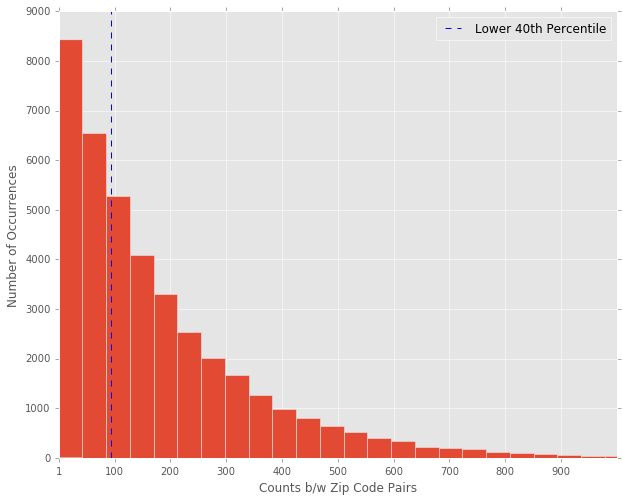

In [2]:
data = np.random.exponential(scale=1.8, size=40000) + 1
plt.hist(data, bins=50)
low_qtile = np.percentile(data, q=40)
plt.axvline(x=low_qtile, linestyle="--", label="Lower 40th Percentile")


plt.xlabel("Counts b/w Zip Code Pairs")
plt.ylabel("Number of Occurrences");
plt.xticks(range(1, 11), [1, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000])
plt.xlim(1, 11);
plt.legend(loc="best");
plt.savefig("edge_weight_hist.png");

# Clustering

- Where do we stand?
    - Have a pruned edges list of zip code pairs
    - The entire edges list is $O(10^7)$ bytes
- Can we identify communities of zip codes that are connected to each other, but to no one else?

# Modularity Maximization

- Tons of algorithms for graph community detection out there
    - Many are too expensive computationally for real-world networks
- Literature review identified set of algorithms based on modularity maximization
    - Facebook and Twitter have successfully applied these to their problems
- There's a terrific Python library out of LANL called NetworkX for working with networks
    - No built-in community detection algorithms
        - Researchers have written open-source implementations of the Louvain Method that couple with NetworkX
    - igraph also considered

# What is Modularity Maximization?

- When trying to understand something I always like to start out with toy problems

![](network_raw.png)

- This network has $n=9$ nodes and $m=14$ edges
- The adjacency matrix $A_{ij}$

![](./adjacency_matrix.png)

# Modularity Maximization

- Say we partition our network into $k$ segments
- To obtain communities we might want to optimize something like:

$$\sum_{l=1}^{k} \sum_{i\in C_l, j\in C_l} A_{ij}$$

- Communities consisting of connected nodes get rewarded
- Not all connections should be treated the same
    - Surely, "social" nodes shouldn't hold as much weight

![](network_raw_comm_bad.jpg)
![](bad_clusts_naive_mod.png)

![](network_raw_comm_good.jpg)
![](good_clusts_naive_mod.png)

# What If We Randomly Rewired the Network?

![](network_raw_rewired1.png)

- If we randomly rewired over and over again, what's the expected number of edges between nodes 1 and 2?
    
$$14 \times \left(\frac{2}{14} \times \frac{3}{14}\right) \times \frac{1}{2} = \frac{3}{14}$$

- In general if node $i$ has degree $d_i$ and node $j$ has degree $d_j$ the expected number of edges is

$$ E_{ij} = \frac{d_i d_j}{2m}$$

# Modularity Maximization

- $A_{ij} - E_{ij}$ is the difference between the true network interaction and expected interactions
- Modularity $Q$ is defined as 

$$Q = \frac{1}{2m} \sum_{l=1}^{k} \sum_{i\in C_l, j\in C_l} A_{ij} - \frac{d_i d_j}{2m}$$

- The $1/2m$ term is to normalize modularity between -1 (bad) and +1 (good)
- As always, we have an optimization problem
    - Pick community membership such that $Q$ is optimized

![](network_raw.png)
- Modularity matrix for our toy problem
![](modularity_matrix.png)
- For $k=2$ clusters, here's a bad community choice with $Q=-0.13$
![](network_raw_comm_bad.jpg)
- For $k=2$ clusters, here's a good community choice with $Q=0.47$
![](network_raw_comm_good.jpg)

# How Do We Actually Optimize Modularity?

- M. Newman and M. Girvan. Finding and evaluating community structure in networks. Physical Review E, 69:026113, 2004.
- Modularity can be rewritten in matrix form. Let $B$ be the modularity matrix and $S \in \{0, 1\}^{{n\times k}}$ a soft community indicator matrix 

$$Q = \frac{1}{2m}\text{ Trace} \left(S^T B S \right)$$

- If values of $S$ are allowed to be continuous, Newman-Girvan showed $Q$ will be optimized when $S$ consists of $k$ eigenvectors corresponding to top eigenvalues of $B$

- For our toy problem the optimizing soft community indicator matrix is
![](./eigenvecs.png)

- Community information captured in eigenvector corresponding to largest eigenvalue
- Apply k-means clustering to get communities

![](./kmeans_after_eigenvecs.png)

# A Common Theme

- Modularity matrix is just one example of a utility matrix that can be constructed for community detection
1. Build utility matrix
    - Latent Space Models 
    - Block Model Approximation
    - Spectral Clustering
        - Graph Laplacian Matrix
    - Modularity Maximization
        - Modularity Matrix
2. Get soft-community indicator by either finding the eigenvectors corresponding to either the largest or smallest eigenvalues (depends on formulation)

3. Apply k-means clustering to soft-community indicator to get community membership

# When In Doubt, What Assumptions Does Your Utility Matrix Make?

- Understanding construction of utility matrix is important when trying to understand why communities are not turning out right 

- Modularity Matrix has a resolution issue
    - Fortunato, S. and Barthélemy, M. Resolution limit in community detection. Proc. Natl. Acad. Sci. USA 104, 36–41 (2007).

# What's $k$?

- This is where most community detection algorithms based on modularity maximization differ

## Divisive Clustering
- Start with $k=2$ communities, then try to break each sub-community into two more communities, ... 
- Iterate. Keep track of modularity
- **Newman-Girvan Algorithm**
    - Uses edge-betweeness as a guide to decide where to divide communities
    - Expensive since edge-betweeness is $O(nm)$

## Agglomerative Clustering
- Start with $k=n$ communities, then glob them together iteratively if modularity is increased
- If performed naively, small communities will be lumped to larger communities. Expensive
- **Louvain Algorithm**
    - Applies heuristics to try to lump together communities of similar size
    - V. Blondel, J. Guillaume, R. Lambiotte, and E. Lefebvre. Fast unfolding of communities in large networks. Journal of Statistical Mechanics: Theory and Experiment, 2008:P10008, 2008.

# Applying Community Detection to Zip Code Data

- Used NetworkX and open-source implementation of Louvain Algorithm
- Problem: modularity is nice mathematical idea but there are practical considerations
- Can't sell a cluster of, say more than 12 zip codes
- Modified Louvain implementation to continue iterations until each cluster less than 12 zip codes in size

# ... Some Exploratory Analysis in Gephi

![](./gephi_graph.png)
![](./logo_all_min_tableau.png)

# Cluster Results 

- Testing how "correct" clusters are is an active research area
- Fortunately, our ultimate objective is to see if clusters could be sold
    - Provide clusters to sales floor. Low testing cost
- Some production implementation costs incurred to keep track of clusters
- How does one price a cluster?
    - Based on demand forecasts, assumptions on real estate agent commissions

- Used Tableau to visualize zip code clusters geographically

![](./tableau_seattle_map.png)
![](./tableau_no_map.png)
![](./logo_all.png)

# Cluster Results

- As a sanity check, we can compare user search data-based clusters against sets of zip code contracts real estate agents have purchased in the past

- User zip adjacency matrix
<img src="matrix_users.png" width="500";/>

- Agent zip adjacency matrix
<img src="matrix_agents.png" width="500";/>

# Ideas for Extending Zip Code Clusters

- No reason to have disjoint clusters
    - BIG-CLAM Algorithm 
        - Yang, Jaewon, and Jure Leskovec. Overlapping community detection at scale: a nonnegative matrix factorization approach. Proceedings of the sixth ACM international conference on Web search and data mining. ACM, 2013.
- Heterogeneous networks
    - Combine user search patterns along with Zillow's database of property values
    - Incorporate agent zip contract clusters  

# Thank You for Following Along!
## Any Questions?